In [ ]:
!pip install scikit-learn

In [ ]:
#Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Preparing the data
# Define paths
train_dir = '/content/drive/MyDrive/Train_Test_Split/train_val'
test_dir = '/content/drive/MyDrive/Train_Test_Split/test'

# Image data generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4144 images belonging to 2 classes.
Found 1034 images belonging to 2 classes.
Found 1365 images belonging to 2 classes.


In [ ]:
# Check the first batch of data
batch = next(train_generator)
images, labels = batch
print(f'Images shape: {images.shape}, Labels shape: {labels.shape}')
print(f'Images range: {images.min()} to {images.max()}')
print(f'Labels: {labels[:10]}')

Images shape: (32, 224, 224, 3), Labels shape: (32,)
Images range: 0.0 to 1.0
Labels: [1. 0. 1. 1. 0. 1. 0. 0. 1. 0.]


In [ ]:
#Building the resnet50 model
# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Custom callback to print learning rate
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1}, Learning Rate: {lr}")

In [ ]:
#Training the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
     callbacks=[reduce_lr, early_stopping, PrintLR()]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5298 - loss: 1.4627Epoch 1, Learning Rate: 0.009999999776482582
130/130 ━━━━━━━━━━━━━━━━━━━━ 1027s 7s/step - accuracy: 0.5300 - loss: 1.4590 - val_accuracy: 0.5155 - val_loss: 518.0706 - learning_rate: 0.0100
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.6002 - loss: 0.8425Epoch 2, Learning Rate: 0.009999999776482582
130/130 ━━━━━━━━━━━━━━━━━━━━ 127s 913ms/step - accuracy: 0.6003 - loss: 0.8420 - val_accuracy: 0.5155 - val_loss: 0.6977 - learning_rate: 0.0100
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.6131 - loss: 0.6678Epoch 3, Learning Rate: 0.009999999776482582
130/130 ━━━━━━━━━━━━━━━━━━━━ 141s 909ms/step - accuracy: 0.6132 - loss: 0.6678 - val_accuracy: 0.5155 - val_loss: 0.7034 - learning_rate: 0.0100
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.6166 - loss: 0.6730Epoch 4, Learning Rate: 0.009999999776482582
130/130 ━━━━━━━━━━━━━━━━━━━━ 137s 870ms/step - accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 703s 17s/step - accuracy: 0.7878 - loss: 0.5660
Test Accuracy: 0.7142857313156128
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 722ms/step
Accuracy: 0.7142857142857143
Precision: 0.7557251908396947
Recall: 0.601823708206687
F1 Score: 0.6700507614213197
              precision    recall  f1-score   support

      Normal       0.69      0.82      0.75       707
        OSCC       0.76      0.60      0.67       658

    accuracy                           0.71      1365
   macro avg       0.72      0.71      0.71      1365
weighted avg       0.72      0.71      0.71      1365



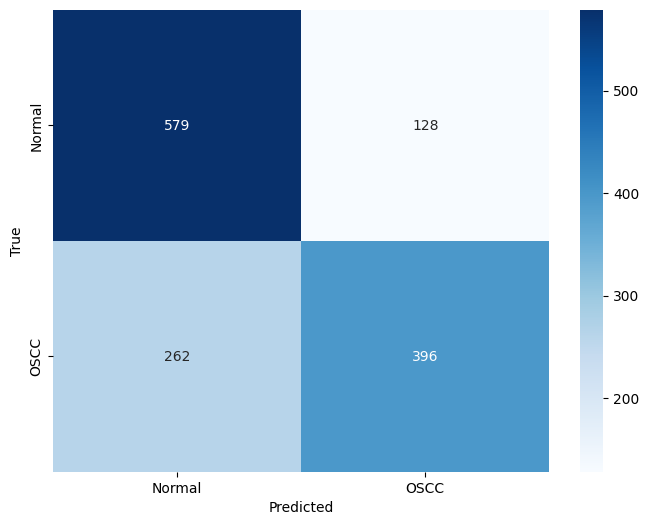

In [ ]:
#Evaluating the model
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# True labels
true_classes = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

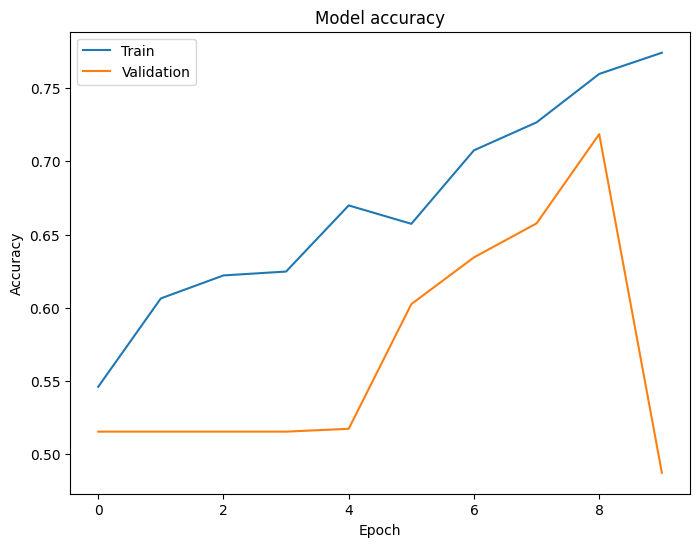

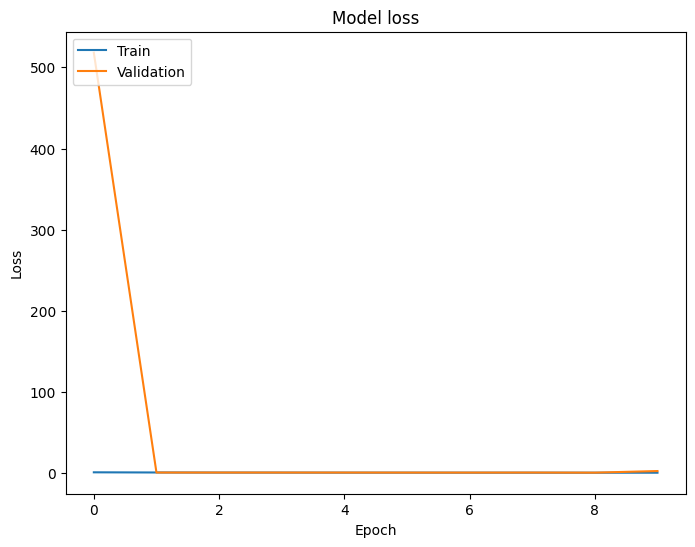

In [ ]:
#Plotting the training and validation accuracy
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
